In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

# 1. Load Data

In [2]:
comment_df = pd.read_csv("/Users/itsyuzhou/Spring2024/thesis_clean/Data/weekly_hate_df.csv")
comment_df['Comment PublishedAt'] = pd.to_datetime(comment_df['Comment PublishedAt'])
comment_df.set_index('Comment PublishedAt', inplace=True)

In [3]:
google_df = pd.read_csv("/Users/itsyuzhou/Spring2024/thesis_clean/Data/google_trends.csv")
google_df['Week'] = pd.to_datetime(google_df['Week'])
google_df.rename(columns={'Chink + Chinaman + Chinkland + Gook + Chinese virus + China virus + Wuhan virus + Kung flu: (United States)': 'Sinophobic Search Terms'}, inplace=True)
google_df.set_index('Week', inplace=True)
google_ts = google_df['Sinophobic Search Terms'].resample('W').mean()

In [4]:
crime_df = pd.read_csv("/Users/itsyuzhou/Spring2024/thesis_clean/Data/hate_crime.csv")
crime_df['incident_date'] = pd.to_datetime(crime_df['incident_date'])
col_keep = ['incident_date', 'state_name', 'offense_name', 'bias_desc']
crime_df = crime_df[col_keep]

asian_crime_df = crime_df[crime_df['bias_desc'].str.contains("Anti-Asian", case=False)]
crime_ts = crime_df.groupby(crime_df['incident_date'].dt.to_period('W')).size()
asian_crime_ts = asian_crime_df.groupby(asian_crime_df['incident_date'].dt.to_period('W')).size()
asian_crime_prop_ts = asian_crime_ts/crime_ts
new_index = asian_crime_prop_ts.index.astype(str).str.split('/').str[1]
asian_crime_prop_ts.index = pd.to_datetime(new_index)


In [5]:
google_ts = google_ts.iloc[4:]
asian_crime_prop_ts = asian_crime_prop_ts.iloc[3:]

print(google_ts.index.equals(comment_df.index))
print(asian_crime_prop_ts.index.equals(comment_df.index))

True
True


In [6]:
cases_df = pd.read_csv('/Users/itsyuzhou/Spring2024/thesis_clean/Data/confirmed_cases.csv')
cases_df = cases_df[['state', 'end_date', 'new_cases', 'new_deaths']]
cases_df['end_date'] = pd.to_datetime(cases_df['end_date'])

aggregated_cases = cases_df.groupby('end_date').agg({
    'new_cases': 'sum',
    'new_deaths': 'sum'
}).reset_index()

start_date = pd.Timestamp('2019-12-20')
end_date = pd.Timestamp('2021-12-31')

aggregated_cases = aggregated_cases[(aggregated_cases['end_date'] >= start_date) & (aggregated_cases['end_date'] <= end_date)]
aggregated_cases.set_index(google_ts.index, inplace=True)

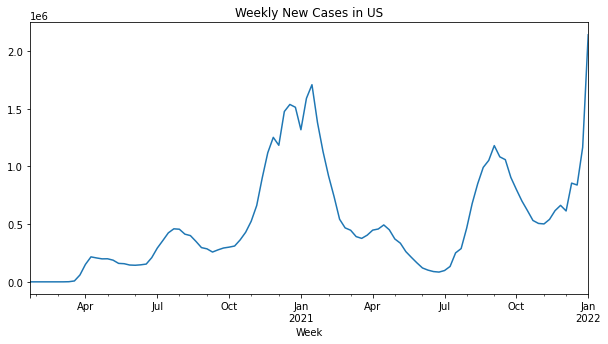

In [7]:
plot = aggregated_cases['new_cases'].plot(figsize=(10, 5), title="Weekly New Cases in US")

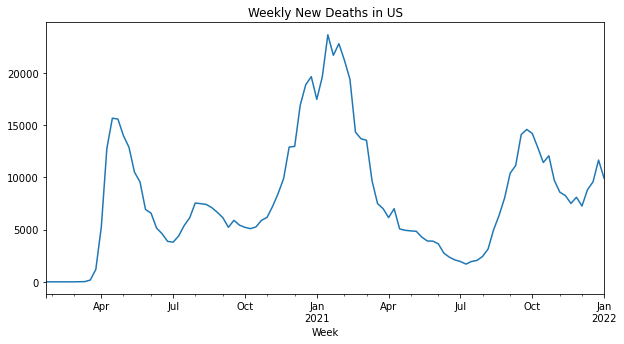

In [8]:
plot = aggregated_cases['new_deaths'].plot(figsize=(10, 5), title="Weekly New Deaths in US")

In [9]:
min_value = aggregated_cases['new_cases'].min()
max_value = aggregated_cases['new_cases'].max()
aggregated_cases['scaled_new_cases'] = (aggregated_cases['new_cases'] - min_value) / (max_value - min_value)

In [10]:
combined_df = pd.DataFrame({
    'Hate Amount': comment_df['hate_amount'].values,
    'Hate Intensity': comment_df['hate_intensity'].values,
    'Google Searches': google_ts.values/100,
    'Anti-Asian Crimes': asian_crime_prop_ts,
    'Confirmed Infecious Cases': aggregated_cases['scaled_new_cases']
    }, index=google_ts.index)

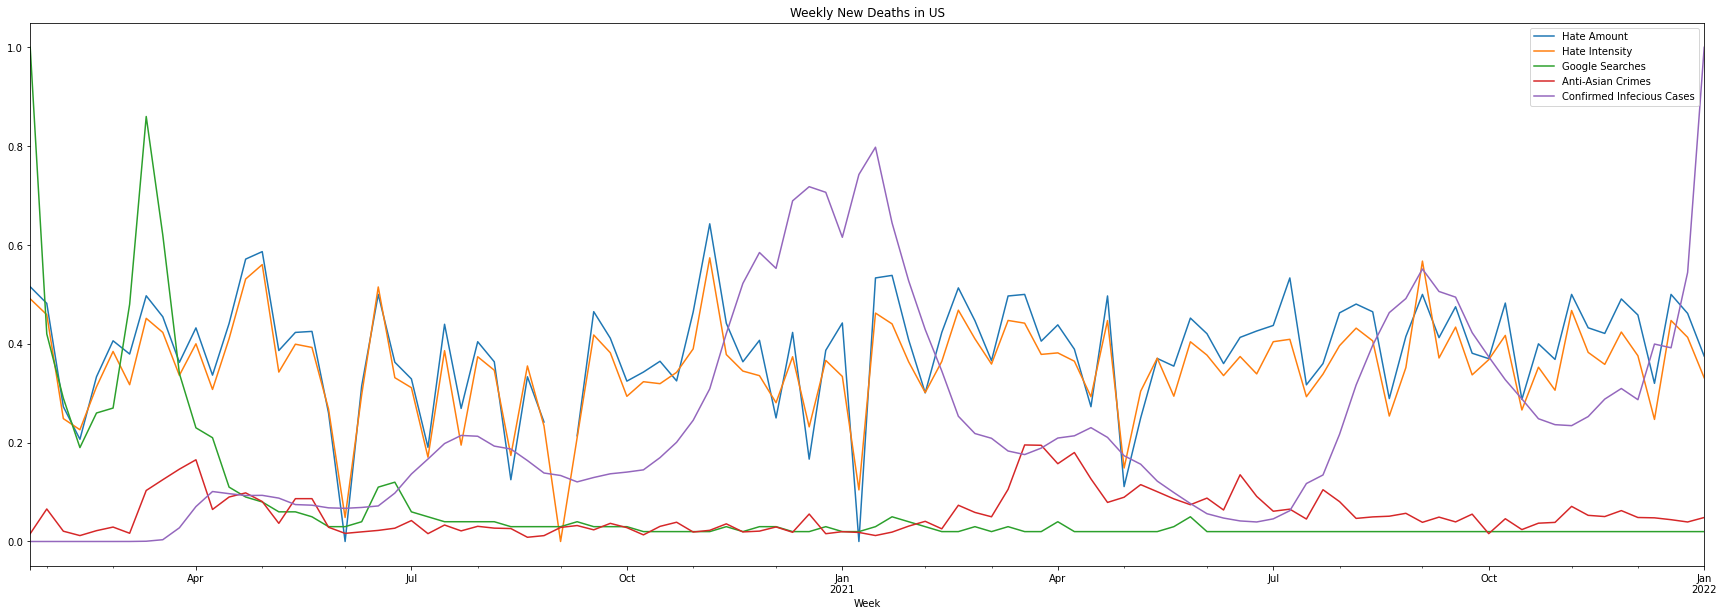

In [11]:
plot = combined_df.plot(figsize=(30, 10), title="Weekly New Deaths in US")

# 2. OLS Regression

In [27]:
y = combined_df['Hate Amount']
x = combined_df['Hate Intensity']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Hate Amount   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1088.
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.49e-55
Time:                        17:22:55   Log-Likelihood:                 200.51
No. Observations:                 102   AIC:                            -397.0
Df Residuals:                     100   BIC:                            -391.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0247      0.013     -1.

In [28]:
y = combined_df['Google Searches']
x = combined_df['Confirmed Infecious Cases']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Google Searches   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     15.98
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000123
Time:                        17:23:12   Log-Likelihood:                 51.838
No. Observations:                 102   AIC:                            -99.68
Df Residuals:                     100   BIC:                            -94.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [29]:
y = combined_df['Hate Amount']
x = combined_df['Confirmed Infecious Cases']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Hate Amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.03819
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.845
Time:                        17:24:01   Log-Likelihood:                 74.297
No. Observations:                 102   AIC:                            -144.6
Df Residuals:                     100   BIC:                            -139.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [31]:
y = combined_df['Anti-Asian Crimes']
x = combined_df['Confirmed Infecious Cases']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Anti-Asian Crimes   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     8.444
Date:                Thu, 18 Apr 2024   Prob (F-statistic):            0.00451
Time:                        17:24:24   Log-Likelihood:                 183.42
No. Observations:                 102   AIC:                            -362.8
Df Residuals:                     100   BIC:                            -357.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [32]:
y = combined_df['Anti-Asian Crimes']
x = combined_df['Hate Amount']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Anti-Asian Crimes   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     4.773
Date:                Thu, 18 Apr 2024   Prob (F-statistic):             0.0312
Time:                        17:24:45   Log-Likelihood:                 181.67
No. Observations:                 102   AIC:                            -359.3
Df Residuals:                     100   BIC:                            -354.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0263      0.014      1.880      

# 3. ARIMA

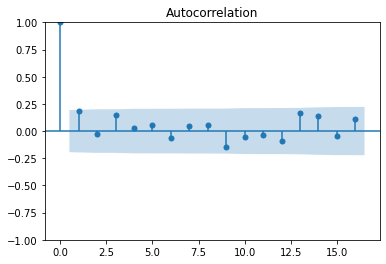

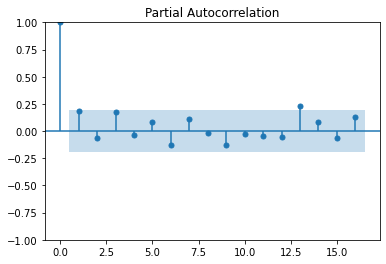

In [41]:
data = combined_df['Hate Amount']
plot_acf(data, lags=16)
plot_pacf(data, lags=16)
plt.show()

- ACF does not show significant autocorrelations at any lag, which suggests that the data does not exhibit strong autoregressive or moving average behaviors 
- ARIMA(0,0,0), 

In [42]:
model = ARIMA(data, order=(0, 0, 0))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=30)

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


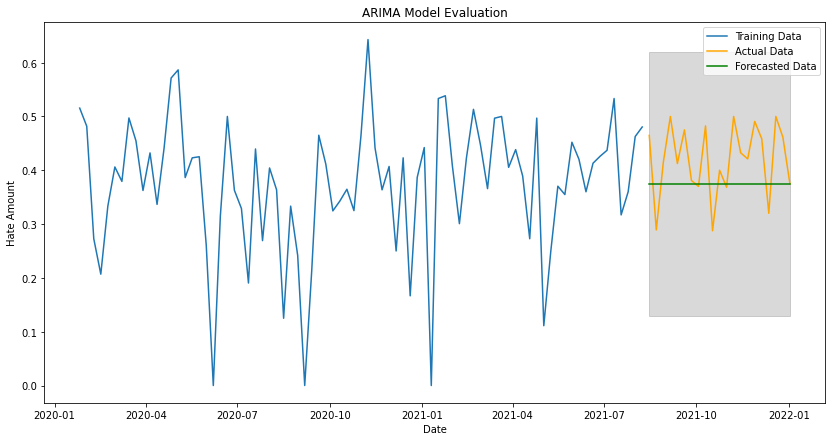

RMSE: 0.07924779382522211


In [44]:
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

model_train = ARIMA(train, order=(0, 0, 0))
model_train_fit = model_train.fit()

test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

mse = mean_squared_error(test, test_forecast_series)
rmse = mse**0.5

plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Hate Amount')
plt.legend()
plt.show()

print('RMSE:', rmse)

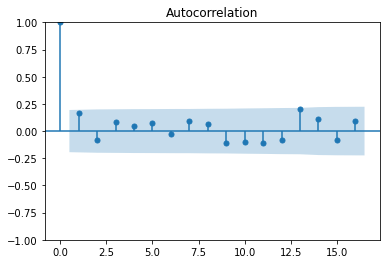

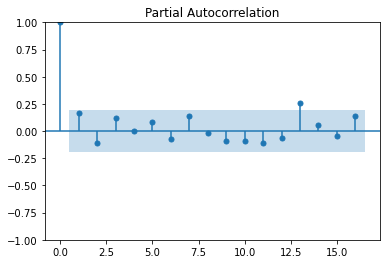

In [45]:
data = combined_df['Hate Intensity']
plot_acf(data, lags=16)
plot_pacf(data, lags=16)
plt.show()

ARIMA(1,0,0)

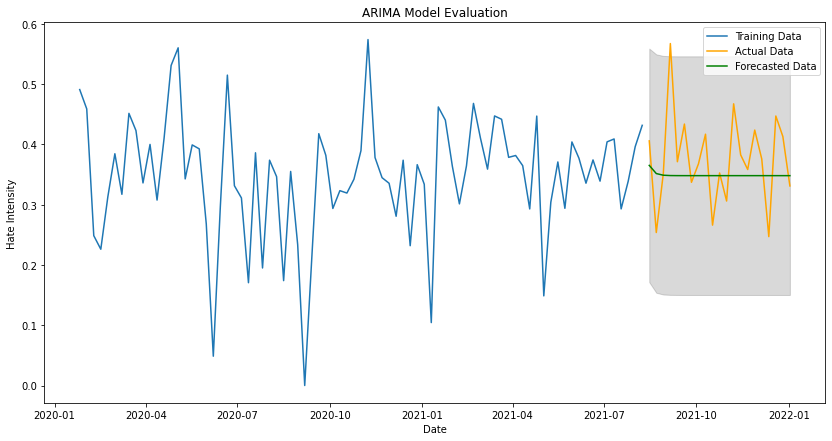

RMSE: 0.07787848049522945


In [46]:
model = ARIMA(data, order=(1, 0, 0))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=30)

train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

model_train = ARIMA(train, order=(1, 0, 0))
model_train_fit = model_train.fit()

test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

mse = mean_squared_error(test, test_forecast_series)
rmse = mse**0.5

plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Hate Intensity')
plt.legend()
plt.show()

print('RMSE:', rmse)

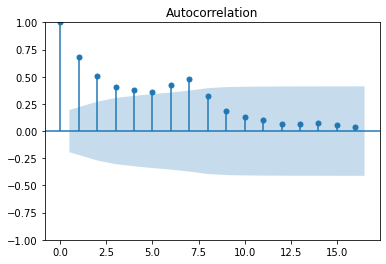

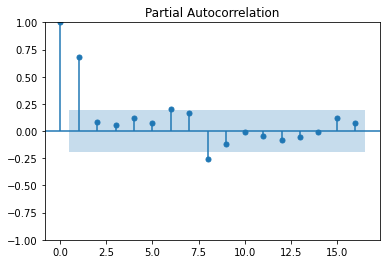

In [47]:
data = combined_df['Google Searches']
plot_acf(data, lags=16)
plot_pacf(data, lags=16)
plt.show()

- The autocorrelation values gradually decrease as the lags increase, but there are several points above the confidence interval for the initial lags. This pattern suggests an autoregressive process because current values seem to be correlated with past values. 
- ARIMA(1,1,0) or ARIMA(1,1,1)

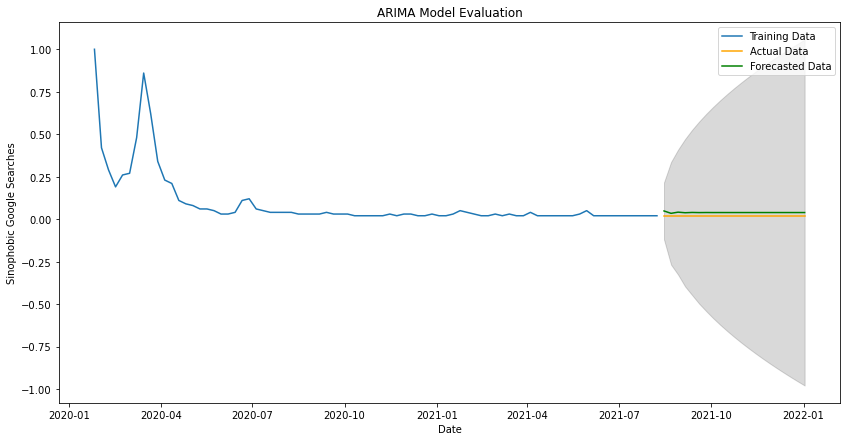

RMSE: 0.0193188714524141


In [49]:
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=30)

train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

model_train = ARIMA(train, order=(1, 1, 1))
model_train_fit = model_train.fit()

test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

mse = mean_squared_error(test, test_forecast_series)
rmse = mse**0.5

plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Sinophobic Google Searches')
plt.legend()
plt.show()

print('RMSE:', rmse)

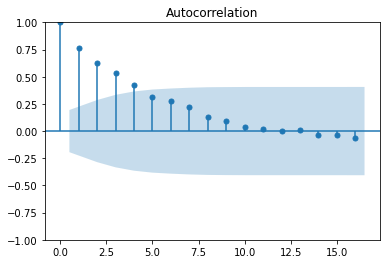

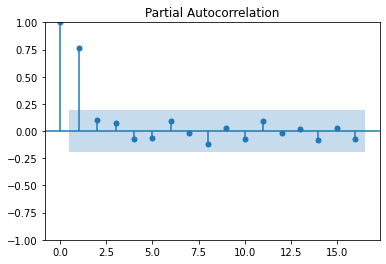

In [50]:
data = combined_df['Anti-Asian Crimes']
plot_acf(data, lags=16)
plot_pacf(data, lags=16)
plt.show()

ARIMA(2,0,0)

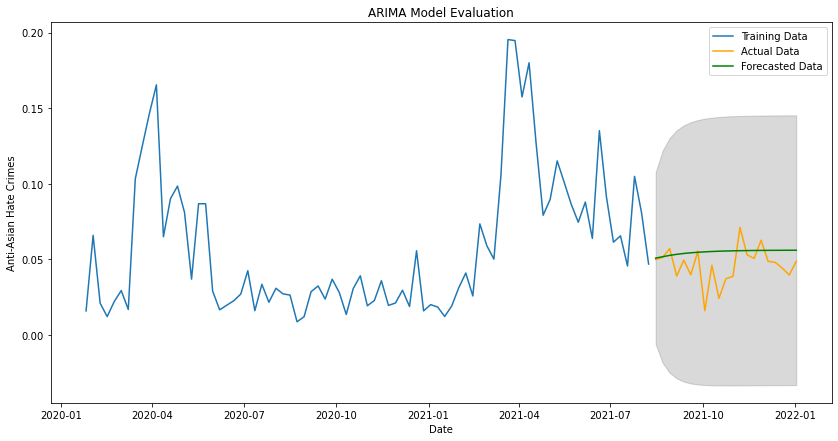

RMSE: 0.01471653792167912


In [51]:
model = ARIMA(data, order=(2, 0, 0))
model_fit = model.fit()
forecast = model_fit.get_forecast(steps=30)

train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

model_train = ARIMA(train, order=(2, 0, 0))
model_train_fit = model_train.fit()

test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

mse = mean_squared_error(test, test_forecast_series)
rmse = mse**0.5

plt.figure(figsize=(14,7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Anti-Asian Hate Crimes')
plt.legend()
plt.show()

print('RMSE:', rmse)

# 4. VAR and Granger Causality

## 4.1. Check Stationary

In [12]:
def adf_test(ts):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [13]:
def kpss_test(ts):
    print("Results of KPSS Test:")
    kpsstest = kpss(ts, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [16]:
combined_df['Hate Amount'] = combined_df['Hate Amount'].fillna(0)
print(adf_test(combined_df['Hate Amount']))
print()
print(kpss_test(combined_df['Hate Amount']))

Results of Dickey-Fuller Test:
Test Statistic                -8.300866e+00
p-value                        4.021909e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64
None

Results of KPSS Test:
Test Statistic           0.364178
p-value                  0.092595
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- ADF Test: p-value = 4.021909e-13 < 0.05, reject null hypothesis that the series has a unit root, thus the hate intensity time series is stationary

- KPSS Test: p-value = 0.092595 > 0.05, fail to reject null hypothesis that the process is trend stationary, thus the hate intensity time series is stationary


In [17]:
print(adf_test(combined_df['Hate Intensity']))
print()
print(kpss_test(combined_df['Hate Intensity']))

Results of Dickey-Fuller Test:
Test Statistic                -8.494479e+00
p-value                        1.286924e-13
#Lags Used                     0.000000e+00
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64
None

Results of KPSS Test:
Test Statistic           0.26517
p-value                  0.10000
Lags Used                0.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64
None


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_84270/336897797.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(ts, regression="c", nlags="auto")


- ADF Test: p-value = 1.286924e-13 < 0.05, reject null hypothesis that the series has a unit root, thus the hate intensity time series is stationary

- KPSS Test: p-value = 0.1 > 0.05, fail to reject null hypothesis that the process is trend stationary, thus the hate intensity time series is stationary

In [18]:
print(adf_test(combined_df['Google Searches']))
print()
print(kpss_test(combined_df['Google Searches']))

Results of Dickey-Fuller Test:
Test Statistic                -9.802929e+00
p-value                        5.928847e-17
#Lags Used                     1.300000e+01
Number of Observations Used    8.800000e+01
Critical Value (1%)           -3.506944e+00
Critical Value (5%)           -2.894990e+00
Critical Value (10%)          -2.584615e+00
dtype: float64
None

Results of KPSS Test:
Test Statistic           0.845369
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_84270/336897797.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(ts, regression="c", nlags="auto")


- ADF Test: p-value = 5.928847e-17 < 0.05, reject null hypothesis that the series has a unit root, thus the hate intensity time series is stationary

- KPSS Test: p-value = 0.01 < 0.05, reject null hypothesis that the process is trend stationary, thus the hate intensity time series is non-stationary

- KPSS indicates non-stationarity and ADF indicates stationarity: The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

In [19]:
print(adf_test(combined_df['Anti-Asian Crimes']))
print('')
print(kpss_test(combined_df['Anti-Asian Crimes']))

Results of Dickey-Fuller Test:
Test Statistic                  -3.684417
p-value                          0.004338
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
None

Results of KPSS Test:
Test Statistic           0.180657
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_84270/336897797.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(ts, regression="c", nlags="auto")


- ADF Test: p-value = 0.004338 < 0.05, reject null hypothesis that the series has a unit root, thus the hate intensity time series is stationary

- KPSS Test: p-value = 0.1 > 0.05, fail to reject null hypothesis that the process is trend stationary, thus the hate intensity time series is stationary

## 4.2 VAR Model

In [62]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [52]:
combined_df

,Hate Amount,Hate Intensity,Google Searches,Anti-Asian Crimes,Confirmed Infecious Cases
Week,,,,,
2020-01-26,0.515480,0.491059,1.00,0.015748,4.670632e-07
2020-02-02,0.481836,0.458962,0.42,0.065789,0.000000e+00
2020-02-09,0.272727,0.248621,0.29,0.020833,3.269442e-06
2020-02-16,0.206897,0.226129,0.19,0.011976,3.736505e-06
2020-02-23,0.333333,0.313061,0.26,0.021898,5.137695e-06
...,...,...,...,...,...
2021-12-05,0.458333,0.375806,0.02,0.048544,2.869440e-01
2021-12-12,0.320000,0.247037,0.02,0.047872,3.995109e-01
2021-12-19,0.500000,0.447182,0.02,0.044118,3.919342e-01


In [53]:
model = VAR(combined_df)
optimal_order = model.select_order()
print(optimal_order.selected_orders)

{'aic': 12, 'bic': 1, 'hqic': 1, 'fpe': 2}


In [56]:
model_fitted = model.fit(maxlags=optimal_order.aic, ic='aic')
resid = model_fitted.resid[optimal_order.aic:]

In [57]:
results = grangercausalitytests(resid[['Hate Amount', 'Hate Intensity']], maxlag=12, verbose=False)
p_values_tgo = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgo.append([lag, test_results[0]['params_ftest'][1]])

Lag 1
	F-Statistic: 1.0706, p-value: 0.3042
Lag 2
	F-Statistic: 0.9225, p-value: 0.4022
Lag 3
	F-Statistic: 0.9851, p-value: 0.4051
Lag 4
	F-Statistic: 1.1780, p-value: 0.3288
Lag 5
	F-Statistic: 0.8511, p-value: 0.5190
Lag 6
	F-Statistic: 1.8771, p-value: 0.0999
Lag 7
	F-Statistic: 1.5613, p-value: 0.1661
Lag 8
	F-Statistic: 1.4211, p-value: 0.2095
Lag 9
	F-Statistic: 1.3692, p-value: 0.2272
Lag 10
	F-Statistic: 1.0982, p-value: 0.3832
Lag 11
	F-Statistic: 0.9400, p-value: 0.5126
Lag 12
	F-Statistic: 0.9632, p-value: 0.4977


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [58]:
results = grangercausalitytests(resid[['Hate Amount', 'Anti-Asian Crimes']], maxlag=12, verbose=False)
p_values_tgo = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgo.append([lag, test_results[0]['params_ftest'][1]])

Lag 1
	F-Statistic: 3.7234, p-value: 0.0575
Lag 2
	F-Statistic: 2.1195, p-value: 0.1276
Lag 3
	F-Statistic: 1.8406, p-value: 0.1480
Lag 4
	F-Statistic: 1.5098, p-value: 0.2097
Lag 5
	F-Statistic: 1.9280, p-value: 0.1024
Lag 6
	F-Statistic: 1.4977, p-value: 0.1948
Lag 7
	F-Statistic: 1.2489, p-value: 0.2924
Lag 8
	F-Statistic: 0.8684, p-value: 0.5487
Lag 9
	F-Statistic: 0.8262, p-value: 0.5951
Lag 10
	F-Statistic: 0.7048, p-value: 0.7151
Lag 11
	F-Statistic: 0.6899, p-value: 0.7406
Lag 12
	F-Statistic: 1.0967, p-value: 0.3884


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [59]:
results = grangercausalitytests(resid[['Hate Intensity', 'Anti-Asian Crimes']], maxlag=12, verbose=False)
p_values_tgo = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgo.append([lag, test_results[0]['params_ftest'][1]])

Lag 1
	F-Statistic: 2.6931, p-value: 0.1050
Lag 2
	F-Statistic: 1.6426, p-value: 0.2007
Lag 3
	F-Statistic: 1.2346, p-value: 0.3039
Lag 4
	F-Statistic: 0.9402, p-value: 0.4465
Lag 5
	F-Statistic: 1.3635, p-value: 0.2503
Lag 6
	F-Statistic: 1.2902, p-value: 0.2758
Lag 7
	F-Statistic: 1.1285, p-value: 0.3587
Lag 8
	F-Statistic: 0.9674, p-value: 0.4713
Lag 9
	F-Statistic: 1.0334, p-value: 0.4274
Lag 10
	F-Statistic: 0.9269, p-value: 0.5175
Lag 11
	F-Statistic: 0.9283, p-value: 0.5228
Lag 12
	F-Statistic: 1.0811, p-value: 0.4004


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [60]:
results = grangercausalitytests(resid[['Confirmed Infecious Cases', 'Anti-Asian Crimes']], maxlag=12, verbose=False)
p_values_tgo = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgo.append([lag, test_results[0]['params_ftest'][1]])

Lag 1
	F-Statistic: 0.0357, p-value: 0.8507
Lag 2
	F-Statistic: 0.2622, p-value: 0.7701
Lag 3
	F-Statistic: 0.0789, p-value: 0.9712
Lag 4
	F-Statistic: 0.1167, p-value: 0.9761
Lag 5
	F-Statistic: 0.0670, p-value: 0.9968
Lag 6
	F-Statistic: 1.1416, p-value: 0.3499
Lag 7
	F-Statistic: 1.0673, p-value: 0.3965
Lag 8
	F-Statistic: 1.3117, p-value: 0.2581
Lag 9
	F-Statistic: 1.1368, p-value: 0.3555
Lag 10
	F-Statistic: 1.1474, p-value: 0.3493
Lag 11
	F-Statistic: 1.0139, p-value: 0.4504
Lag 12
	F-Statistic: 0.8061, p-value: 0.6424


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [61]:
results = grangercausalitytests(resid[['Confirmed Infecious Cases', 'Hate Amount']], maxlag=12, verbose=False)
p_values_tgo = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgo.append([lag, test_results[0]['params_ftest'][1]])

Lag 1
	F-Statistic: 0.0018, p-value: 0.9659
Lag 2
	F-Statistic: 0.0654, p-value: 0.9367
Lag 3
	F-Statistic: 0.1044, p-value: 0.9573
Lag 4
	F-Statistic: 0.2284, p-value: 0.9215
Lag 5
	F-Statistic: 0.4644, p-value: 0.8013
Lag 6
	F-Statistic: 0.3397, p-value: 0.9131
Lag 7
	F-Statistic: 0.3162, p-value: 0.9436
Lag 8
	F-Statistic: 0.2419, p-value: 0.9808
Lag 9
	F-Statistic: 0.2266, p-value: 0.9891
Lag 10
	F-Statistic: 0.1508, p-value: 0.9986
Lag 11
	F-Statistic: 0.2041, p-value: 0.9965
Lag 12
	F-Statistic: 0.2579, p-value: 0.9927


/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [65]:
granger_causation_matrix(combined_df, combined_df.columns, 1)  

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packa

,Hate Amount_x,Hate Intensity_x,Google Searches_x,Anti-Asian Crimes_x,Confirmed Infecious Cases_x
Hate Amount_y,1.0000,0.3494,0.6606,0.3409,0.6776
Hate Intensity_y,0.8697,1.0000,0.4869,0.2774,0.7095
Google Searches_y,0.4023,0.2807,1.0000,0.2874,0.1808
Anti-Asian Crimes_y,0.4554,0.6534,0.0165,1.0000,0.2049
Confirmed Infecious Cases_y,0.4880,0.6785,0.8920,0.7696,1.0000


In [68]:
granger_causation_matrix(combined_df, combined_df.columns, 2)  

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packa

,Hate Amount_x,Hate Intensity_x,Google Searches_x,Anti-Asian Crimes_x,Confirmed Infecious Cases_x
Hate Amount_y,1.0000,0.0959,0.3595,0.3409,0.3877
Hate Intensity_y,0.3207,1.0000,0.3344,0.2774,0.5485
Google Searches_y,0.4023,0.2807,1.0000,0.1458,0.1808
Anti-Asian Crimes_y,0.4554,0.6534,0.0087,1.0000,0.2049
Confirmed Infecious Cases_y,0.0624,0.1962,0.8920,0.4856,1.0000


In [67]:
granger_causation_matrix(combined_df, combined_df.columns, 4)  

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packa

,Hate Amount_x,Hate Intensity_x,Google Searches_x,Anti-Asian Crimes_x,Confirmed Infecious Cases_x
Hate Amount_y,1.0000,0.0959,0.3595,0.3409,0.3877
Hate Intensity_y,0.2404,1.0000,0.3344,0.2774,0.5485
Google Searches_y,0.4023,0.2807,1.0000,0.1458,0.1808
Anti-Asian Crimes_y,0.4554,0.6534,0.0015,1.0000,0.2049
Confirmed Infecious Cases_y,0.0253,0.0651,0.8490,0.4856,1.0000


In [69]:
granger_causation_matrix(combined_df, combined_df.columns, 6)  

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packa

,Hate Amount_x,Hate Intensity_x,Google Searches_x,Anti-Asian Crimes_x,Confirmed Infecious Cases_x
Hate Amount_y,1.0000,0.0959,0.1968,0.3409,0.0687
Hate Intensity_y,0.2404,1.0000,0.1024,0.2774,0.5048
Google Searches_y,0.4023,0.2807,1.0000,0.1458,0.1808
Anti-Asian Crimes_y,0.4554,0.6534,0.0000,1.0000,0.0409
Confirmed Infecious Cases_y,0.0253,0.0651,0.8490,0.4856,1.0000


In [70]:
granger_causation_matrix(combined_df, combined_df.columns, 10)  

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packa

,Hate Amount_x,Hate Intensity_x,Google Searches_x,Anti-Asian Crimes_x,Confirmed Infecious Cases_x
Hate Amount_y,1.0000,0.0959,0.0032,0.3409,0.0241
Hate Intensity_y,0.1279,1.0000,0.0018,0.2774,0.2807
Google Searches_y,0.0003,0.0004,1.0000,0.0712,0.1808
Anti-Asian Crimes_y,0.1221,0.2027,0.0000,1.0000,0.0000
Confirmed Infecious Cases_y,0.0253,0.0651,0.8490,0.4856,1.0000


In [71]:
granger_causation_matrix(combined_df, combined_df.columns, 12)  

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packa

,Hate Amount_x,Hate Intensity_x,Google Searches_x,Anti-Asian Crimes_x,Confirmed Infecious Cases_x
Hate Amount_y,1.0000,0.0959,0.0009,0.3409,0.0241
Hate Intensity_y,0.1279,1.0000,0.0014,0.2774,0.2807
Google Searches_y,0.0002,0.0002,1.0000,0.0712,0.1808
Anti-Asian Crimes_y,0.1221,0.2027,0.0000,1.0000,0.0000
Confirmed Infecious Cases_y,0.0253,0.0651,0.8490,0.4856,1.0000
